# Mlib 協調フィルタリングによるレコメンデーション

In [2]:
#recommend  sample code .  if you know more info , please see url.
#http://qiita.com/kenmatsu4/items/42fa2f17865f7914688d

In [26]:
import os, sys
import pandas as pd
import numpy as np
from datetime import datetime as dt

# データの準備

In [27]:
# Exampleデータの読み込み
df = pd.read_csv('sample_movielens_ratings.txt',
                 delimiter='::', names=('uid', 'iid', 'rating','time'),engine='python')
pv_rating = df.pivot(index='uid', columns='iid', values='rating').fillna(0)

#uidはユーザーID, iidはアイテム(映画)ID、中のデータはユーザーごとの映画のrating
pv_rating

iid,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
uid,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,3.0,1.0,0.0,2.0,0.0,0.0,0.0,4.0,...,0.0,3.0,4.0,0.0,1.0,2.0,1.0,0.0,1.0,1.0
1,0.0,0.0,2.0,1.0,2.0,0.0,1.0,0.0,0.0,3.0,...,0.0,1.0,2.0,1.0,2.0,0.0,1.0,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,3.0,0.0,1.0,0.0,5.0,1.0,...,1.0,0.0,4.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,0.0,0.0,0.0,3.0,3.0,1.0,...,0.0,1.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0
5,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,3.0,...,4.0,2.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,1.0
6,1.0,1.0,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,2.0,0.0,0.0,1.0,2.0,1.0,0.0,0.0,0.0
7,0.0,1.0,2.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0
8,1.0,0.0,4.0,2.0,2.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,4.0,3.0,1.0,1.0,1.0


uidはユーザーID, iidはアイテム(映画)ID、中のデータはユーザーごとの映画のrating


# データの可視化

(30, 100)


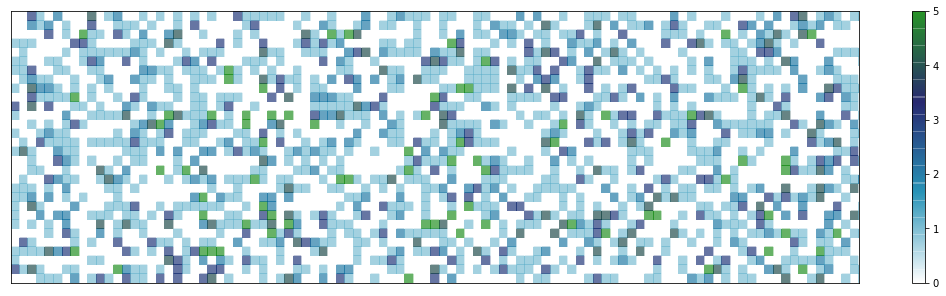

In [28]:
# Ratingの可視化
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm

n_y, n_x = pv_rating.shape
X, Y = np.meshgrid(range(n_x+1), range(n_y+1))
Z = pv_rating.as_matrix()
Z.astype(np.float32)
Z = Z[::-1,:]
print Z.shape
fig = plt.figure(figsize=(19,5))
ax = plt.subplot(111)
plt.ylim(0,30)
plt.xlim(0,99)
ax.set_xticks([])
ax.set_yticks([])
cax = ax.pcolor(X, Y, Z, cmap=cm.get_cmap('ocean_r'), alpha=0.6)

cbar = fig.colorbar(cax, ticks=range(6))
#cbar.ax.set_yticklabels(['5', '4', '3', '2', '1', '0'])# vertically oriented colorbar
plt.show()

# レコメンデーションの実行

MLlibにあるALS(Alternating Least Squares)という手法でレコメンデーションを行います。これは協調フィルタリングという手法で、あるユーザと嗜好(ここでは映画のrating)の類似した他のユーザの情報を用いて推論を行う方法です。映画のコンテンツはある意味無視して、ユーザーの行動から推論するところが特徴の一つです。

In [29]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

def limitter(x):
    if x > 5:   # 5以上の値は5とする
        return 5
    elif x < 0: # マイナスの値は0とする
        return 0
    else:
        return x

## トレーニングデータの準備

In [30]:
sc_rating = sc.parallelize(df.as_matrix())
ratings = sc_rating.map(lambda l: Rating(int(l[0]), int(l[1]), float(l[2])))

## ALS(Alternating Least Squares)でレコメンデーションの生成

In [31]:
rank = 10
numIterations = 10
model = ALS.train(ratings, rank, numIterations)

## 学習したデータからデータがなかった部分にratingを付与する

In [32]:
n_y, n_x = pv_rating.shape
X, Y = np.meshgrid(range(n_x+1), range(n_y+1))
f_XY = np.c_[Y.flatten(), X.flatten()]
predictions_all = model.predictAll(sc.parallelize(f_XY)).map(lambda r: ((r[0], r[1]), limitter(r[2]) ))

def selector(x, y):
    if x is None:
        return y
    elif x != 0:
        return x
    else:
        return y

## すでにratingがあるところはキープして、無いところにALSで計算した値を代入

In [33]:
ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).rightOuterJoin(predictions_all).map(lambda r: ((r[0][0], r[0][1]), selector(r[1][0], r[1][1])) )
                                                                                      
result = np.array(ratesAndPreds.sortBy(lambda x: (x[0], x[1])).collect())
Z = result[:,1]
Z = Z.astype(np.float32).reshape(pv_rating.shape)[::-1,:]

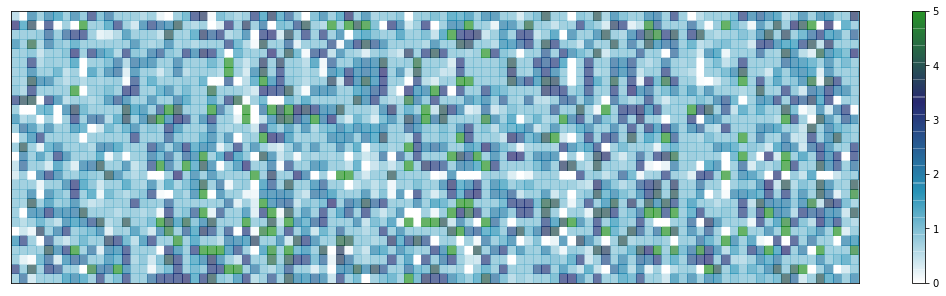

In [35]:
fig = plt.figure(figsize=(19,5))
ax = plt.subplot(111)
plt.ylim(0,29)
plt.xlim(0,99)
ax.set_xticks([])
ax.set_yticks([])

cax = ax.pcolor(X, Y, Z, cmap=cm.get_cmap('ocean_r'), alpha=0.6)
cbar = fig.colorbar(cax, ticks=range(6))

plt.show()
#空白だったところに数値が入ったところがレコメンデーション情報

## 平均２乗誤差

In [36]:
# 精度の計算
testdata = ratings.map(lambda p: (p[0], p[1]))

predictions = model.predictAll(testdata).map(lambda r: ((r[0], r[1]), limitter(r[2]) ))

ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)

MSE = ratesAndPreds.map(lambda r: (r[1][0] - r[1][1])**2).mean()
print("Mean Squared Error = " + str(MSE))

Mean Squared Error = 0.049170396546


In [40]:
ratesAndPreds = ratings.map(lambda r: ((r[0], r[1]), r[2])).rightOuterJoin(predictions_all).map(lambda r: ((r[0][0], r[0][1]), (r[1][0], r[1][1])) )
print("((uid, iid), (rating, predict))")
ratesAndPreds.collect()[10:30]
#ratingがあるところは近い数字になっており、Noneのところは予測したratingが入っています。

((uid, iid), (rating, predict))


[((29, 17), (3.0, 3.3637914176903365)),
 ((23, 51), (None, 0.5405086171781561)),
 ((11, 7), (None, 3.7460943886653877)),
 ((28, 10), (None, 2.2271575218237665)),
 ((9, 93), (None, 2.3065184599020556)),
 ((23, 91), (None, 2.873070926985629)),
 ((17, 13), (2.0, 2.0597024898279583)),
 ((16, 38), (1.0, 1.1518975544412537)),
 ((22, 12), (None, 0.7517603316010177)),
 ((12, 50), (4.0, 4.277840780036688)),
 ((11, 15), (None, 1.9077815516203087)),
 ((1, 21), (3.0, 2.499918315585782)),
 ((22, 52), (None, 3.1651563963100724)),
 ((0, 14), (None, 0.8017469998903577)),
 ((8, 94), (None, 0.15522765343375955)),
 ((29, 89), (None, 1.386084216825149)),
 ((5, 1), (1.0, 1.1576700483360733)),
 ((4, 42), (None, 2.664373932595163)),
 ((25, 13), (None, 1.4444178058244321)),
 ((3, 55), (None, 0.5602400561219989))]